# Preparation Agent
This notebook is dedicated to the data extraction and basic preparation done in the notebook 'Preparation Agent'. We start by installing dependencies that we need.

In [1]:
#installing dependencies
import sqlite3
import pandas as pd  


#where database is located
dbfile = '/Users/sofyakonchakova/Desktop/Data_Science/data/home-assistant_v2.db'


### SQL Data Pulling

I removed the code for other databases as we will stick to the one called 'states'. In my own database I see states and attributes in different databases. 
<font color='red'>Check with Alona how she managed to put them together.
</font>

In [10]:
#acessing the states database
with sqlite3.connect(dbfile) as con:
    cur = con.cursor()
    cur.execute("SELECT * FROM states")
    states = cur.fetchall()

    
#converting it to the pandas data frame
from_states_db = []

for result in states:
    result = list(result)
    from_states_db.append(result)

columns = ["state_id","domain","entity_id","state","attributes","event_id","last_changed","last_updated","created","old_state_id"]
states_df = pd.DataFrame(from_states_db, columns = columns)

In [11]:
states_df.head()

,state_id,domain,entity_id,state,attributes,event_id,last_changed,last_updated,created,old_state_id
0,11244860,zwave,zwave.switch_cr,ready,"{""node_id"":15,""node_name"":""Shenzhen Neo Electr...",11287622,2021-11-28 20:46:35.720593,2021-12-02 03:12:05.162304,2021-12-02 03:12:05.162304,NaN
1,11244861,sensor,sensor.switch_cr_exporting,False,"{""node_id"":15,""value_index"":32,""value_instance...",11287623,2021-12-02 03:12:05.162807,2021-12-02 03:12:05.162807,2021-12-02 03:12:05.162807,NaN
2,11244862,sensor,sensor.switch_cr_energy,6.86,"{""node_id"":15,""value_index"":0,""value_instance""...",11287624,2021-12-02 03:12:05.191776,2021-12-02 03:12:05.191776,2021-12-02 03:12:05.191776,NaN
3,11244863,sensor,sensor.switch_cr_previous_reading_1,6.86,"{""node_id"":15,""value_index"":1,""value_instance""...",11287625,2021-12-02 03:12:05.220377,2021-12-02 03:12:05.220377,2021-12-02 03:12:05.220377,NaN
4,11244864,sensor,sensor.switch_cr_interval_1,301,"{""node_id"":15,""value_index"":2,""value_instance""...",11287626,2021-12-02 03:12:05.252402,2021-12-02 03:12:05.252402,2021-12-02 03:12:05.252402,NaN


### Data Unpacking
We received data frame that has dictionaries in column value. In this section, we bring the data frame to the wide format, additionally unpacking the column. After that I specify that I need values in kWh and choose nodes. <font color='red'>Note: user should specify the nodes. How does he do it?
</font>

In [15]:
df = states_df.copy()

#Substitution of the values 
df['attributes'] = df['attributes'].apply(lambda x: x.replace('true','True'))
df['attributes'] = df['attributes'].apply(lambda x: x.replace('false','False'))
df['attributes'] = df['attributes'].apply(lambda x: x.replace('null','None'))

#treating the values as real dictionaries and unpacking
df['attributes']=df['attributes'].apply(lambda dat: dict(eval(dat)))
df2 = pd.json_normalize(df['attributes'])
result = pd.concat([df,df2], axis = 1).drop('attributes', axis = 1)

#dropping columns that have at least 10000 non-na values
trial = result.copy()
trial = trial.dropna(thresh=10000,axis = 1)

In [18]:
#here i specify which node i use. how the user specifies it?
kwh_data = trial[trial.unit_of_measurement.isin(['kWh']) & trial.node_id.isin([3,15,34,46])]

kwh_data_long = kwh_data[['node_id','last_changed', 'power_consumption','entity_id']]
kwh_data_wide = pd.pivot(kwh_data_long, index = ['last_changed', 'entity_id'], columns = 'node_id', values = 'power_consumption')

#filling nas with zeros 
kwd_data_wide = kwh_data_wide.fillna(0)
df = kwd_data_wide.reset_index()
REFIT_df = df.reset_index().copy()

In [19]:
#three nodes out of use?
df.sum()

node_id
last_changed    2021-12-02 03:12:05.1917762021-12-02 03:12:05....
entity_id       sensor.switch_cr_energysensor.switch_cr_previo...
3.0                                                       4923.51
15.0                                                          0.0
34.0                                                          0.0
46.0                                                      2510.22
dtype: object

### Outlier Truncation
Here comes <font color='red'> the first issue </font>, the consumption which was reported is really low. When we apply outlier truncation, all values that are not zero becoming zeros. Therefore, should we skip outlier truncation step?

In [25]:
class Preparation_Agent:
    def __init__(self):
        self.input = df

prep = Preparation_Agent()


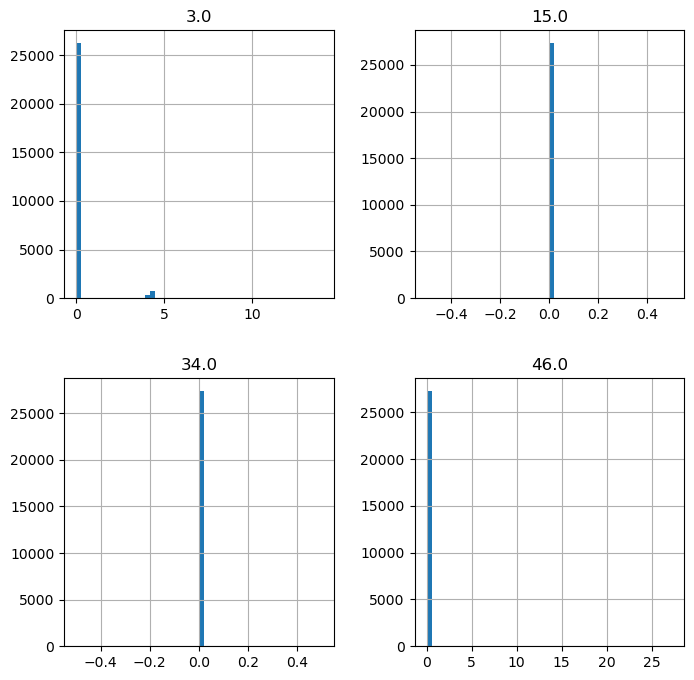

In [26]:
# Histogram
prep.input.hist(bins=50, figsize=(8,8));

In [34]:
def outlier_truncation(self, series, factor=1.5, verbose=0):
    from tqdm import tqdm
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3-q1
    
    lower_bound = q1 - factor*iqr
    upper_bound = q3 + factor*iqr
    
    output = []
    counter = 0
    for item in (tqdm(series, desc=f'[outlier truncation: {series.name}]') if verbose != 0 else series):
        if item > upper_bound:
            output.append(int(upper_bound))
            counter += 1
        elif item < lower_bound:
            output.append(int(lower_bound))
            counter += 1
        else:
            output.append(item)
    print(f'[outlier truncation: {series.name}]: {counter} outliers were truncated.') if verbose != 0 else None 
    return output

# add the function to the class and delete global function
setattr(Preparation_Agent, 'outlier_truncation', outlier_truncation)
del outlier_truncation

In [35]:
prep.input.describe().round(2)

node_id,3.0,15.0,34.0,46.0
count,27347.00,27347.0,27347.0,27347.00
mean,0.18,0.0,0.0,0.09
std,0.92,0.0,0.0,1.55
min,0.00,0.0,0.0,0.00
25%,0.00,0.0,0.0,0.00
50%,0.00,0.0,0.0,0.00
75%,0.00,0.0,0.0,0.00
max,13.96,0.0,0.0,27.25


#outlier truncation brings zero help, will not include it in preparation agent

In [36]:
df_1 = pd.DataFrame()
df_1['3.0'] = df[3.0].copy()

df_1['3.0'] = prep.outlier_truncation(prep.input[46.0], verbose = 1)
df_1.describe().round(2)

[outlier truncation: 46.0]: 100%|██████████| 27347/27347 [00:00<00:00, 1279523.80it/s]

[outlier truncation: 46.0]: 95 outliers were truncated.


,3.0
count,27347.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


### MinMax Scaling

In [37]:
def scale(df, features='all', kind='MinMax', verbose=0):
    output = df.copy()
    features = df.select_dtypes(include=['int', 'float']).columns if features == 'all' else features
    
    if kind == 'MinMax':
        from sklearn.preprocessing import MinMaxScaler
        
        scaler = MinMaxScaler()
        output[features] = scaler.fit_transform(df[features])
        print('[MinMaxScaler] Finished scaling the data.') if verbose != 0 else None
    else:
        raise InputError('Chosen scaling method is not available.')
    return output 

# add to the class
setattr(Preparation_Agent, 'scale', scale)
#del scale

In [38]:
prep = Preparation_Agent()
household_s = scale(df, verbose = 1)

[MinMaxScaler] Finished scaling the data.


/Users/sofyakonchakova/Conda/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/sofyakonchakova/Conda/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [39]:
household_s.describe().round(3)

node_id,3.0,15.0,34.0,46.0
count,27347.000,27347.0,27347.0,27347.000
mean,0.013,0.0,0.0,0.003
std,0.066,0.0,0.0,0.057
min,0.000,0.0,0.0,0.000
25%,0.000,0.0,0.0,0.000
50%,0.000,0.0,0.0,0.000
75%,0.000,0.0,0.0,0.000
max,1.000,0.0,0.0,1.000


## Feature Creation

### Resampling by hour



In [50]:
#aggregating per hour
household_s.last_changed = pd.to_datetime(household_s.last_changed)
data = household_s.resample('60T', on="last_changed").mean()
data.describe().round(3)


node_id,3.0,15.0,34.0,46.0
count,247.000,247.0,247.0,247.000
mean,0.011,0.0,0.0,0.002
std,0.035,0.0,0.0,0.022
min,0.000,0.0,0.0,0.000
25%,0.000,0.0,0.0,0.000
50%,0.000,0.0,0.0,0.000
75%,0.000,0.0,0.0,0.000
max,0.242,0.0,0.0,0.323


In [46]:
def plot_consumption(df, features='all', figsize='default', threshold=None, title='Consumption'):
    import matplotlib.pyplot as plt

    df = df.copy()
    features = [column for column in df.columns if column not in ['Unix', 'Issues']] if features == 'all' else features

    fig, ax = plt.subplots(figsize=figsize) if figsize != 'default' else plt.subplots()
    if threshold != None:
        df['threshold'] = [threshold]*df.shape[0]
        ax.plot(df['threshold'], color = 'tab:red')
    for feature in features:
        ax.plot(df[feature])
    ax.legend(['threshold'] + features) if threshold != None else ax.legend(features)
    ax.set_title(title);



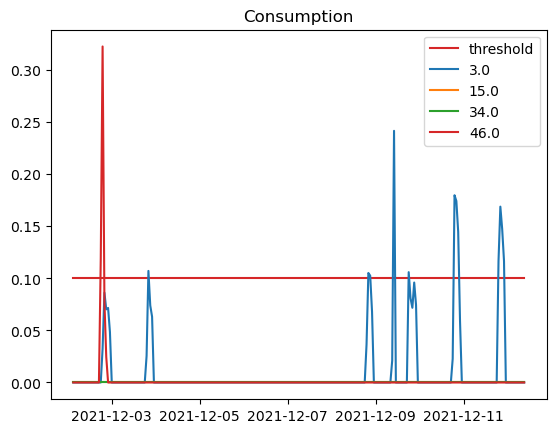

In [53]:
plot_consumption(data, threshold=.10)

### Device Usage Feature

In [55]:
def get_device_usage(df, device, threshold):
    return (df.loc[:, device] > threshold).astype('int')

In [59]:
# hourly usage of device 'Television Site' in the household on Jan 1, 2014
usage_col = get_device_usage(data, 3.0, .15)
usage_col.describe().round(3)

count    247.000
mean       0.016
std        0.126
min        0.000
25%        0.000
50%        0.000
75%        0.000
max        1.000
Name: 3.0, dtype: float64

In [247]:
def pipeline_extracting(self, df, params):
    import sqlite3
    import pandas as pd 
    
     

3 - kitchen lamp 
15 - child room lamp
34 - bedroom lamp
46 - living room
41 - 
48 - rolls for windows, disregard


-> aggregate per hour


-> focus on integration